In [1]:
import torch
import torchvision.transforms as T
from dalle_pytorch import VQGanVAE
from dalle.models import DALLE_Klue_Roberta
from transformers import AutoTokenizer

import yaml
from easydict import EasyDict

/home/brad/anaconda3/envs/kodalle/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dalle_config_path = 'configs/dalle_config.yaml'
dalle_path = 'results/dalle_uk_final.pt'

vqgan_config_path = '/home/brad/Development/taming-transformers/configs/VQGAN_blue.yaml'
vqgan_path = '/home/brad/Development/taming-transformers/logs/2022-07-21T12-44-12_VQGAN_blue/checkpoints/best.ckpt'

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [3]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

with open(dalle_config_path, "r") as f:
    dalle_config = yaml.load(f, Loader=yaml.Loader)
    DALLE_CFG = EasyDict(dalle_config["DALLE_CFG"])

DALLE_CFG.VOCAB_SIZE = tokenizer.vocab_size

vae = VQGanVAE(
    vqgan_model_path=vqgan_path, 
    vqgan_config_path=vqgan_config_path
)

DALLE_CFG.IMAGE_SIZE = vae.image_size

dalle_params = dict(
    num_text_tokens=tokenizer.vocab_size,
    text_seq_len=DALLE_CFG.TEXT_SEQ_LEN,
    depth=DALLE_CFG.DEPTH,
    heads=DALLE_CFG.HEADS,
    dim_head=DALLE_CFG.DIM_HEAD,
    reversible=DALLE_CFG.REVERSIBLE,
    loss_img_weight=DALLE_CFG.LOSS_IMG_WEIGHT,
    attn_types=DALLE_CFG.ATTN_TYPES,
    ff_dropout=DALLE_CFG.FF_DROPOUT,
    attn_dropout=DALLE_CFG.ATTN_DROPOUT,
    stable=DALLE_CFG.STABLE,
    shift_tokens=DALLE_CFG.SHIFT_TOKENS,
    rotary_emb=DALLE_CFG.ROTARY_EMB,
)

dalle = DALLE_Klue_Roberta(
    vae=vae, 
    wte_dir="models/roberta_large_wte.pt",
    wpe_dir="models/roberta_large_wpe.pt",
    **dalle_params
    ).to(device)


loaded_obj = torch.load(dalle_path, map_location=torch.device('cuda:0'))
dalle_params, vae_params, weights = loaded_obj['hparams'], loaded_obj['vae_params'], loaded_obj['weights']
dalle.load_state_dict(weights)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from /home/brad/Development/taming-transformers/logs/2022-07-21T12-44-12_VQGAN_blue/checkpoints/best.ckpt and /home/brad/Development/taming-transformers/configs/VQGAN_blue.yaml
1024 16 16


<All keys matched successfully>

In [30]:
text = '볼이 넓은 계란형 얼굴이며 앞머리가 이마의 양쪽 끝을 가리고 있어 모양은 보이지 않는다.   오른쪽 턱의 각진 부분이 왼쪽에 비해 아래로 내려와 있고 왼쪽은 약간 완만한 형태이다.  턱끝으로 내려오는 턱모양은 약간 둥근형으로 보인다. 왼쪽의 볼이 더 평평하고 넓은 편이다.'

encoded_dict = tokenizer(
    text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=DALLE_CFG.TEXT_SEQ_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,  # for RoBERTa
).to(device)

encoded_text = encoded_dict['input_ids']
mask = encoded_dict['attention_mask']

print(encoded_text)
print(mask)

tensor([[    0,  1164,  2052,   748,  2073,  8493,  2444,  3977,  2052,  2307,
         24819,  2116,  8950,  2079,  8108,   711,  2069,  5246,  2088,  1513,
          2051,  4616,  2073,  3783,  2118,  1380,  2259,  2062,    18,  6735,
          1778,  2079,   544,  2043,  3884,  2052,  6561,  2170,  4357,  4402,
          2200, 13567,  1513,  2088,  6561,  2073,  4943, 18026,  2470,  4337,
         28674,    18,  1778,  3141,  6233,  9005,  2259,  1778,  2391,  2221,
          2073,  4943, 15207,     2]], device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


In [31]:
image = dalle.generate_images(
    encoded_text,
    mask=mask,
    filter_thres=0.9  # topk sampling at 0.9
)

image.shape

torch.Size([1, 3, 256, 256])

볼이 넓은 계란형 얼굴이며 앞머리가 이마의 양쪽 끝을 가리고 있어 모양은 보이지 않는다.   오른쪽 턱의 각진 부분이 왼쪽에 비해 아래로 내려와 있고 왼쪽은 약간 완만한 형태이다.  턱끝으로 내려오는 턱모양은 약간 둥근형으로 보인다. 왼쪽의 볼이 더 평평하고 넓은 편이다.


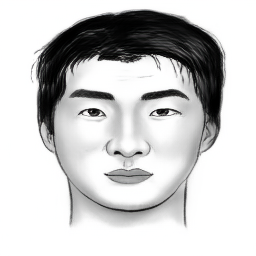

In [32]:
print(text)

T.ToPILImage()(image.squeeze())

In [16]:
def text_to_montage(text):
    encoded_dict = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=DALLE_CFG.TEXT_SEQ_LEN,
        add_special_tokens=True,
        return_token_type_ids=True,  # for RoBERTa
    ).to(device)

    encoded_text = encoded_dict['input_ids']
    mask = encoded_dict['attention_mask']

    image = dalle.generate_images(
        encoded_text,
        mask=mask,
        filter_thres=0.9  # topk sampling at 0.9
    )

    return T.ToPILImage()(image.squeeze())

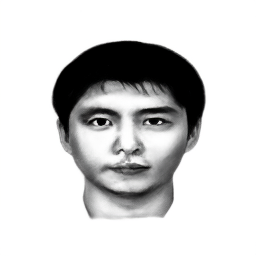

In [18]:
text = '이마라인 가운데가 아래로 살짝 내려와 있어 M모양을 띄고 있으며 가르마의 구분 없이 모두 올려져 있으나 헤어라인 가운데에서 살짝 오른편으로 헤어젤을 바른 듯 조금 나뉜 모습도 보인다. 옆머리는 왼쪽은 귓바퀴 시작 지점까지 내려와 있으며 오른쪽은 귀에 바로 닿을 듯 내려와 있다.'

text_to_montage(text)

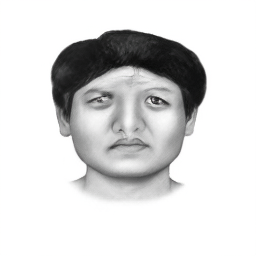

In [19]:
text = '각진 얼굴에 광대는 매끄럽고 큰 볼을 가지고 있어 약간 후덕한 인상을 준다. 눈매의 라인이 부드러워 따뜻한 인상을 주며 누구에게나 친절을 베풀 것 같은 인물이다. 입매가 부드럽고 약간 얇은 듯해서 말하기 좋아하는 사람 같기도 하다.'

text_to_montage(text)

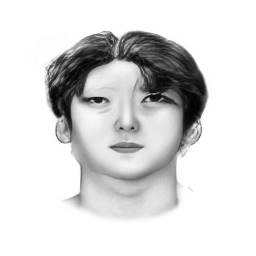

In [20]:
text = '눈매와 입매가 부드럽고 미소짓고 있는 모습으로  성품이 착하고 유한 사람으로 보인다. 약간 여성스러운 성격일 수도 있을 것 같으며 누구에게나 친절하고 어진 모습으로 대해주는 편안한 사람으로 느껴진다.'

text_to_montage(text)